In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import graphviz
from sklearn.preprocessing import LabelEncoder

In [3]:
data = pd.read_csv("data/telco-churn.csv")

In [4]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
data.shape

(7043, 21)

In [6]:
data.drop('customerID', axis = 1, inplace = True)

In [7]:
data.iloc[0]

gender                        Female
SeniorCitizen                      0
Partner                          Yes
Dependents                        No
tenure                             1
PhoneService                      No
MultipleLines       No phone service
InternetService                  DSL
OnlineSecurity                    No
OnlineBackup                     Yes
DeviceProtection                  No
TechSupport                       No
StreamingTV                       No
StreamingMovies                   No
Contract              Month-to-month
PaperlessBilling                 Yes
PaymentMethod       Electronic check
MonthlyCharges                 29.85
TotalCharges                   29.85
Churn                             No
Name: 0, dtype: object

In [8]:
data['gender'] = LabelEncoder().fit_transform(data['gender'])
data['Partner'] = LabelEncoder().fit_transform(data['Partner'])
data['Dependents'] = LabelEncoder().fit_transform(data['Dependents'])
data['PhoneService'] = LabelEncoder().fit_transform(data['PhoneService'])
data['MultipleLines'] = LabelEncoder().fit_transform(data['MultipleLines'])
data['InternetService'] = LabelEncoder().fit_transform(data['InternetService'])
data['OnlineSecurity'] = LabelEncoder().fit_transform(data['OnlineSecurity'])
data['OnlineBackup'] = LabelEncoder().fit_transform(data['OnlineBackup'])
data['DeviceProtection'] = LabelEncoder().fit_transform(data['DeviceProtection'])
data['TechSupport'] = LabelEncoder().fit_transform(data['TechSupport'])
data['StreamingTV'] = LabelEncoder().fit_transform(data['StreamingTV'])
data['StreamingMovies'] = LabelEncoder().fit_transform(data['StreamingMovies'])
data['Contract'] = LabelEncoder().fit_transform(data['Contract'])
data['PaperlessBilling'] = LabelEncoder().fit_transform(data['PaperlessBilling'])
data['PaymentMethod'] = LabelEncoder().fit_transform(data['PaymentMethod'])
data['Churn'] = LabelEncoder().fit_transform(data['Churn'])

In [9]:
data.dtypes

gender                int32
SeniorCitizen         int64
Partner               int32
Dependents            int32
tenure                int64
PhoneService          int32
MultipleLines         int32
InternetService       int32
OnlineSecurity        int32
OnlineBackup          int32
DeviceProtection      int32
TechSupport           int32
StreamingTV           int32
StreamingMovies       int32
Contract              int32
PaperlessBilling      int32
PaymentMethod         int32
MonthlyCharges      float64
TotalCharges         object
Churn                 int32
dtype: object

In [9]:
data.TotalCharges = pd.to_numeric(data.TotalCharges, errors='coerce')

In [10]:
X = data.copy()
X.drop("Churn", inplace = True, axis = 1)
Y = data.Churn

In [11]:
X_train, X_test = X[:int(X.shape[0]*0.8)].values, X[int(X.shape[0]*0.8):].values
Y_train, Y_test = Y[:int(Y.shape[0]*0.8)].values, Y[int(Y.shape[0]*0.8):].values

In [12]:
train = xgb.DMatrix(X_train, label=Y_train)
test = xgb.DMatrix(X_test, label=Y_test)

In [17]:
test_error = {}
for i in range(20):
    param = {'max_depth':i, 'eta':0.1, 'silent':1, 'objective':'binary:hinge'}
    num_round = 50
    model_metrics = xgb.cv(param, train, num_round, nfold = 10)
    test_error[i] = model_metrics.iloc[-1]['test-error-mean']

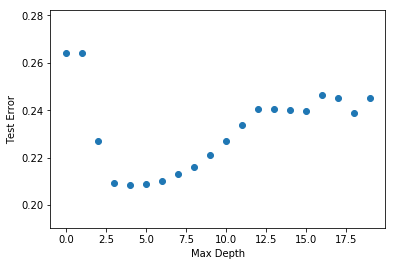

In [18]:
plt.scatter(test_error.keys(),test_error.values())
plt.xlabel('Max Depth')
plt.ylabel('Test Error')
plt.show()

In [61]:
param = {'max_depth':4, 'eta':0.1, 'silent':1, 'objective':'binary:hinge'}
num_round = 300
model_metrics = xgb.cv(param, train, num_round, nfold = 10)

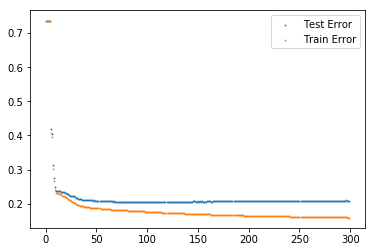

In [66]:
plt.scatter(range(300),model_metrics['test-error-mean'], s = 0.7, label = 'Test Error')
plt.scatter(range(300),model_metrics['train-error-mean'], s = 0.7, label = 'Train Error')
plt.legend()
plt.show()

In [70]:
param = {'max_depth':4, 'eta':0.1, 'silent':1, 'objective':'binary:hinge'}
num_round = 100
model = xgb.train(param, train, num_round)
preds = model.predict(test)
accuracy = accuracy_score(Y[int(Y.shape[0]*0.8):].values, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 79.77%


In [71]:
model.save_model('churn-model.model')